# Housing Price Prediction Regression Model

## Imports

In [10]:
#Import packages

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler, MaxAbsScaler,QuantileTransformer
from sklearn.preprocessing import PowerTransformer,Normalizer,OrdinalEncoder,FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from scipy import stats 
import pandas as pd
import numpy as np
import base64,os,random,gc
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

In [11]:
import matplotlib.pyplot as plotter
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import plotly.express as px

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from functools import partial
import optuna
from optuna import trial
import xgboost as xgb
from xgboost import XGBRegressor
import catboost
from catboost import CatBoostRegressor
import lightgbm as lgbm
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn import datasets
optuna.logging.set_verbosity(optuna.logging.WARNING)
from lightgbm import *
pd.set_option("display.max_columns", None)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance

import warnings
warnings.filterwarnings('ignore')

## Data Reading

In [15]:
train = pd.read_csv('.\input\housing_price_dataset.csv')

In [16]:
#Split data into train/test
train, test = train_test_split(train, test_size=0.2, random_state=42)
train=train.reset_index(drop=True)
test=test.reset_index(drop=True)

In [17]:
display(train.head())
display(test.head())

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2498,2,3,Rural,2021,288178.195769
1,2380,5,3,Urban,1977,374155.921378
2,2274,5,2,Urban,1957,242571.549240
3,2215,5,1,Suburb,1977,150048.317779
4,2078,2,3,Suburb,1962,241134.908315


,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,1894,5,1,Rural,1975,170835.035713
1,1001,5,3,Suburb,1963,126913.469998
2,2264,4,3,Suburb,1964,246611.883092
3,2299,5,1,Suburb,1999,244250.462969
4,2651,2,1,Suburb,1951,271127.650112


## EDA

train 
------


SquareFeet      0
Bedrooms        0
Bathrooms       0
Neighborhood    0
YearBuilt       0
Price           0
dtype: int64


test 
------


SquareFeet      0
Bedrooms        0
Bathrooms       0
Neighborhood    0
YearBuilt       0
Price           0
dtype: int64

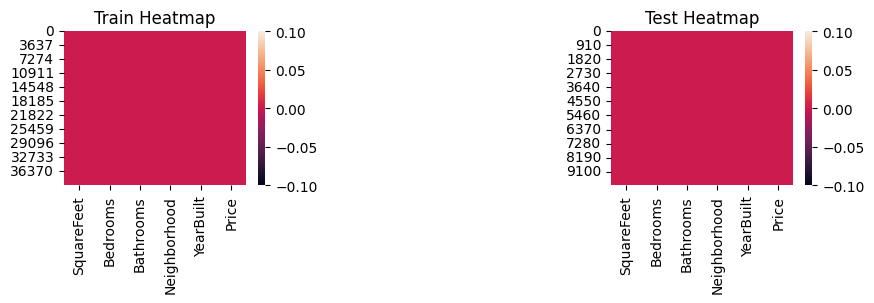

In [18]:
print('train \n------')
display(train.isnull().sum())
print('\ntest \n------')
display(test.isnull().sum())

plt.figure(figsize=(10,2))

plt.subplot(1,3,1)
plt.title('Train Heatmap')
sns.heatmap(train.isnull())

plt.subplot(1,3,3)
plt.title('Test Heatmap')
sns.heatmap(test.isnull())
plt.show()

Train Null Values


<Axes: >

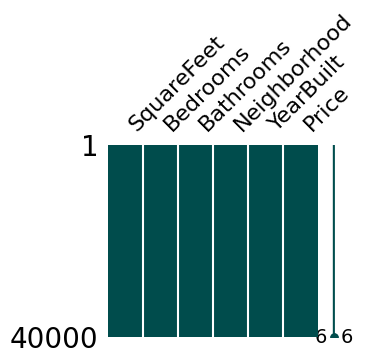

In [19]:
print('Train Null Values')
msno.matrix(df=train, figsize=(3,2.5),color=(0,.3,.3))

Test Null Values


<Axes: >

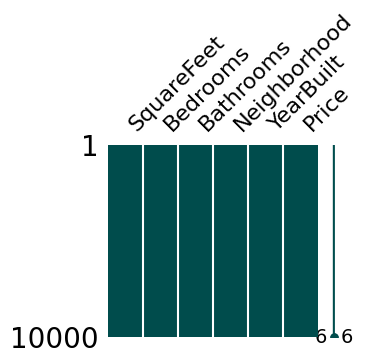

In [20]:
print('Test Null Values')
msno.matrix(df=test, figsize=(3,2.5),color=(0,.3,.3))

In [21]:
#No Null values --> Ok 
print('train \n------')
display(train.info())
print('\ntest \n------')
display(test.info())

train 
------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SquareFeet    40000 non-null  int64  
 1   Bedrooms      40000 non-null  int64  
 2   Bathrooms     40000 non-null  int64  
 3   Neighborhood  40000 non-null  object 
 4   YearBuilt     40000 non-null  int64  
 5   Price         40000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 1.8+ MB


None


test 
------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SquareFeet    10000 non-null  int64  
 1   Bedrooms      10000 non-null  int64  
 2   Bathrooms     10000 non-null  int64  
 3   Neighborhood  10000 non-null  object 
 4   YearBuilt     10000 non-null  int64  
 5   Price         10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


None

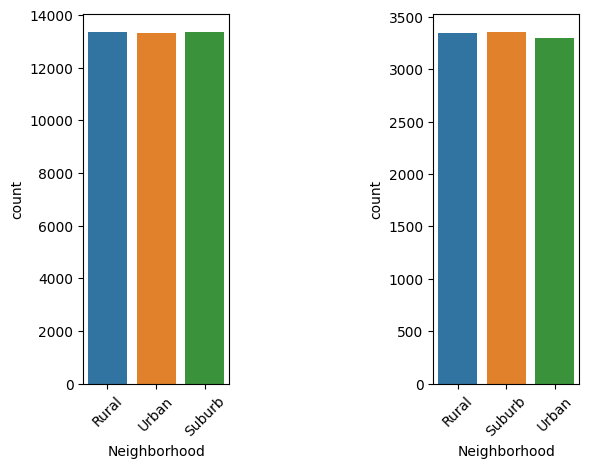

In [22]:
plt.subplot(1, 3, 1)
sns.countplot(x = train["Neighborhood"],palette='tab10')
plotter.xticks(rotation = 45)

plt.subplot(1, 3, 3)
sns.countplot(x = test["Neighborhood"],palette='tab10')
plotter.xticks(rotation = 45)
plt.show()

In [23]:
#Do One Hot Encoding on Neighborhood Type (train)
#Note to self: OHE systematially by alpha order
#Knowing this, fetch neighborhood categories and feed to alpha-sort
#method for new columns labels

#Create instance of encoder
encoder_train = OneHotEncoder(handle_unknown='ignore')

#Encode Neighborhood column
encoder_train_df = (pd.DataFrame(encoder_train.fit_transform
                (train[['Neighborhood']]).toarray()))

#Rename encoded df columns
encoder_train_df.columns = ['Rural','Suburban','Urban']

#Merge Encoded Columns with train set, drop 'Neighborhood' column
train = train.join(encoder_train_df)
train.drop('Neighborhood',axis=1,inplace=True)
display(train.head())

,SquareFeet,Bedrooms,Bathrooms,YearBuilt,Price,Rural,Suburban,Urban
0,2498,2,3,2021,288178.195769,1.0,0.0,0.0
1,2380,5,3,1977,374155.921378,0.0,0.0,1.0
2,2274,5,2,1957,242571.549240,0.0,0.0,1.0
3,2215,5,1,1977,150048.317779,0.0,1.0,0.0
4,2078,2,3,1962,241134.908315,0.0,1.0,0.0


In [24]:
#Do One Hot Encoding on Neighborhood Type (test)

#Create instance of encoder
encoder_test = OneHotEncoder(handle_unknown='ignore')

#Encode Neighborhood column
encoder_test_df = (pd.DataFrame(encoder_test.fit_transform
                (test[['Neighborhood']]).toarray()))

#Rename encoded df columns
encoder_test_df.columns = ['Rural','Suburban','Urban']

#Merge Encoded Columns with test set, drop 'Neighborhood' column
test = test.join(encoder_test_df)
test.drop('Neighborhood',axis=1,inplace=True)
display(test.head())

,SquareFeet,Bedrooms,Bathrooms,YearBuilt,Price,Rural,Suburban,Urban
0,1894,5,1,1975,170835.035713,1.0,0.0,0.0
1,1001,5,3,1963,126913.469998,0.0,1.0,0.0
2,2264,4,3,1964,246611.883092,0.0,1.0,0.0
3,2299,5,1,1999,244250.462969,0.0,1.0,0.0
4,2651,2,1,1951,271127.650112,0.0,1.0,0.0


In [25]:
#Describe features
train_feature = train.columns.drop('Price').tolist()
train_feature

['SquareFeet',
 'Bedrooms',
 'Bathrooms',
 'YearBuilt',
 'Rural',
 'Suburban',
 'Urban']

In [26]:
train[train_feature].describe().T.style.bar(subset=['mean'],\
                 color=px.colors.qualitative.G10[0])\
                 .background_gradient(subset=['std'], cmap='BuPu')\
                 .background_gradient(subset=['50%'], cmap='Reds')
                            

,count,mean,std,min,25%,50%,75%,max
SquareFeet,40000.000000,2005.959300,575.235245,1000.000000,1512.000000,2008.000000,2506.000000,2999.000000
Bedrooms,40000.000000,3.503100,1.115043,2.000000,3.000000,4.000000,4.000000,5.000000
Bathrooms,40000.000000,1.997200,0.816002,1.000000,1.000000,2.000000,3.000000,3.000000
YearBuilt,40000.000000,1985.390125,20.687968,1950.000000,1967.000000,1985.000000,2003.000000,2021.000000
Rural,40000.000000,0.333350,0.471416,0.000000,0.000000,0.000000,1.000000,1.000000
Suburban,40000.000000,0.334100,0.471681,0.000000,0.000000,0.000000,1.000000,1.000000
Urban,40000.000000,0.332550,0.471133,0.000000,0.000000,0.000000,1.000000,1.000000


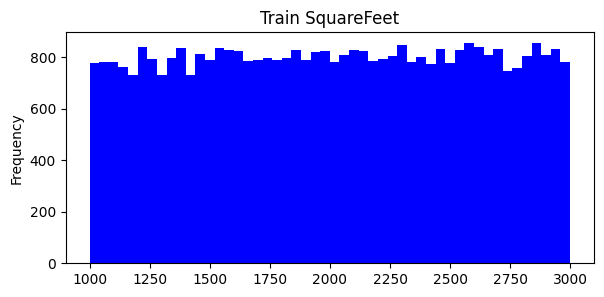

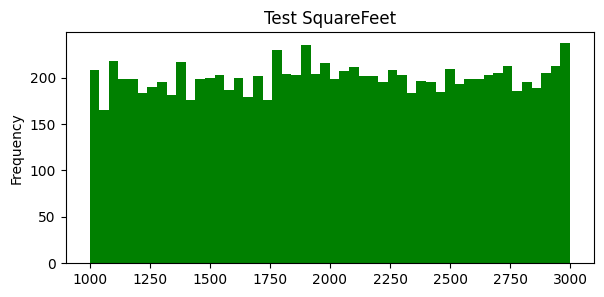

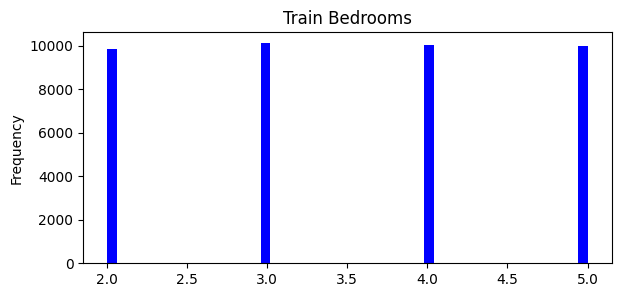

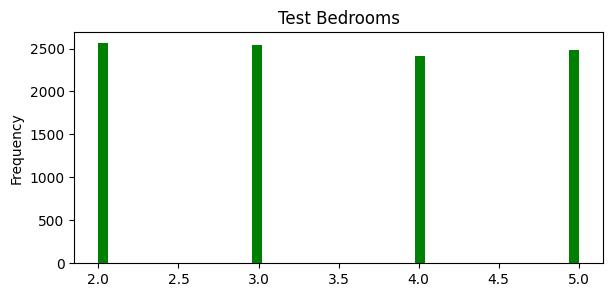

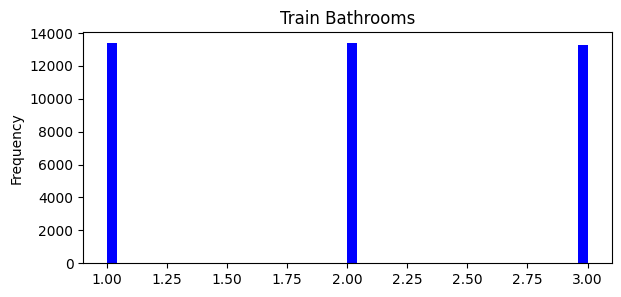

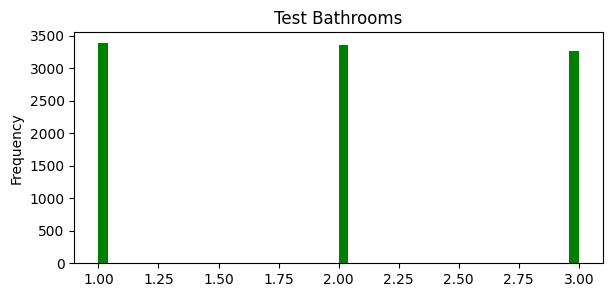

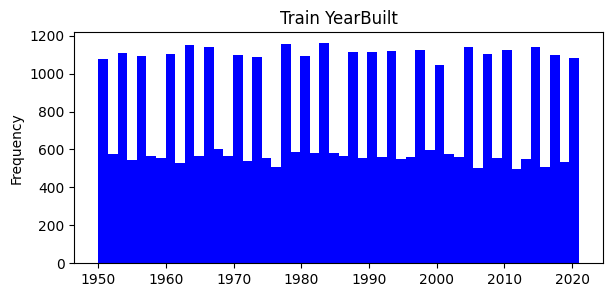

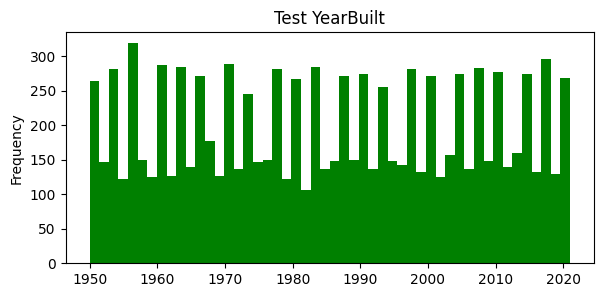

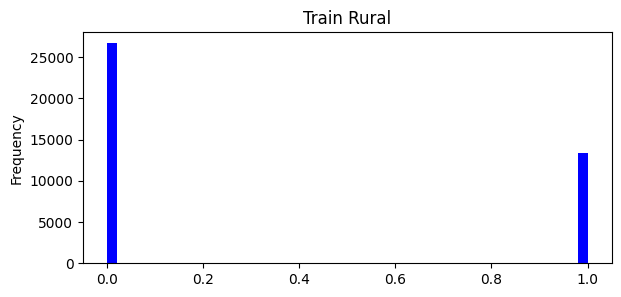

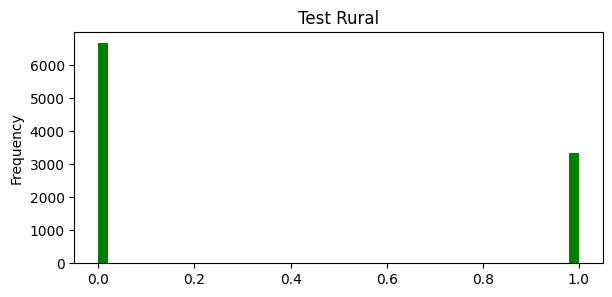

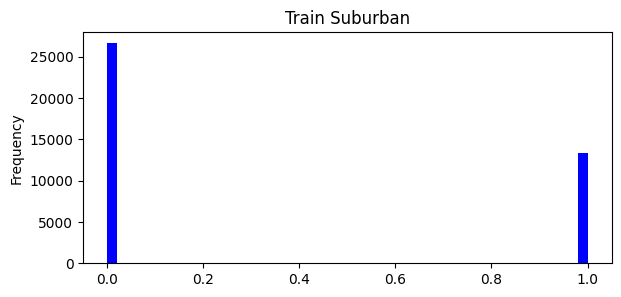

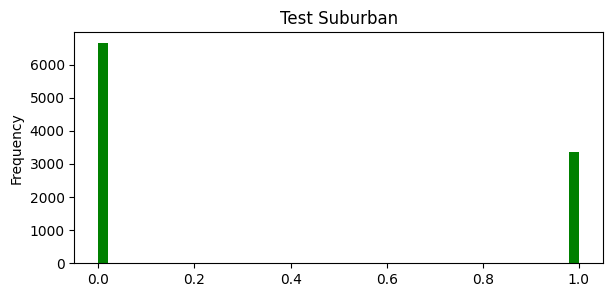

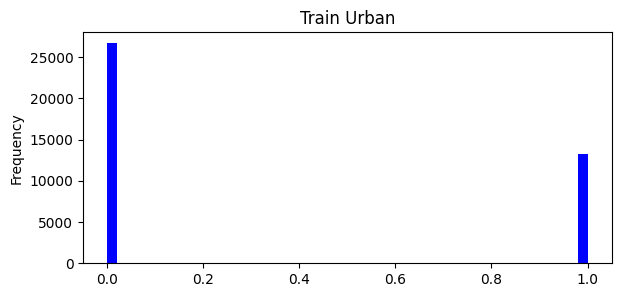

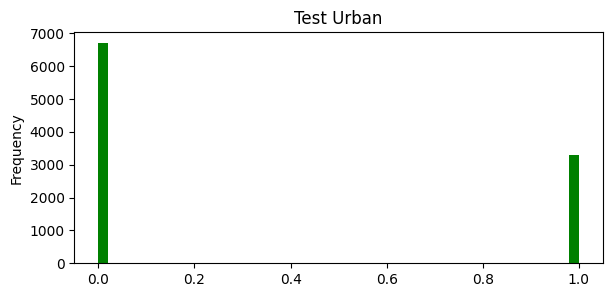

In [27]:
#Create histograms of all features

for feat in train_feature:
    #Create a training feature histogram
    plt.figure(figsize=(15,3))
    plt.subplot(1,2,1)
    ax1=train[feat].plot(kind='hist',bins=50,color='blue')
    plt.title('Train ' + feat)

    #Create a testing feature histogram
    plt.figure(figsize=(15,3))
    plt.subplot(1,2,2, sharex=ax1)
    ax2=test[feat].plot(kind='hist',bins=50,color='green')
    plt.title('Test ' + feat)
    plt.show()

In [28]:
data = pd.concat([train,test])

In [ ]:
data.info()

In [29]:
#Output kurtosis and skew of features
#General Guidelines for Normality:
#Skewness = [-1,1]
#Kurtosis = [-2,2]
#We would say our data is fairly normal and ok

for feat in train_feature:
    print(f"{feat}:\n---------")
    print("Skewness: %f" % data[feat].skew())
    print("Kurtosis: %f" % data[feat].kurt() + "\n")



SquareFeet:
---------
Skewness: -0.011162
Kurtosis: -1.189926

Bedrooms:
---------
Skewness: 0.004640
Kurtosis: -1.356057

Bathrooms:
---------
Skewness: 0.008408
Kurtosis: -1.497577

YearBuilt:
---------
Skewness: 0.005557
Kurtosis: -1.196839

Rural:
---------
Skewness: 0.706237
Kurtosis: -1.501289

Suburban:
---------
Skewness: 0.701948
Kurtosis: -1.507330

Urban:
---------
Skewness: 0.713215
Kurtosis: -1.491385



## Feature Selection

#### Beginning to create a model

In [30]:
#Plots feature importance

X_data_feature = train.drop(columns=['Price'],axis=1)
y_data_feature = train['Price']
num_features = len(X_data_feature.columns)

In [31]:
def model_feat_imp(model_type, model_name, plot_args):
    #Instantiate XGBR Model
    model = [model_type]
    max_xlim, xticks = plot_args
    #Fit model type to each feature
    model = [model[i].fit(X_data_feature,y_data_feature) 
             for i in range(len(model))]
    
    for i in range(len(model)):
        print(f'{model_name}: \n',
              model[i].feature_importances_)
        feat_importances = pd.Series(model[i].feature_importances_,
                                    index=X_data_feature.columns)
        #Using pd built in plot --> Hence pd.Series above
        feat_importances.nlargest(num_features).plot(kind='barh',
                                    color='royalblue')
        #max_feat = feat_importances.nlargest(1)[0]
        plt.xticks(np.arange(0,max_xlim,xticks))
        plt.show()

XGBRegressor: 
 [0.79493606 0.0468097  0.03271281 0.03140875 0.02917238 0.03405336
 0.03090694]


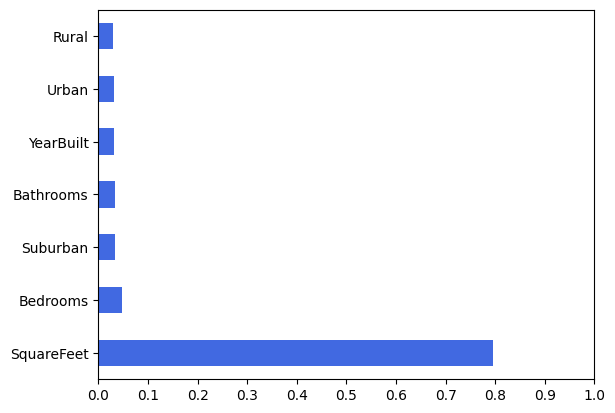

In [32]:
#XGBRegressor model feature imp
model_feat_imp(XGBRegressor(),"XGBRegressor",(1.1,0.1))

[LightGBM] [Info] Total Bins 343
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 7
[LightGBM] [Info] Start training from score 224795.672923
LGBMRegressor: 
 [1333  400  249  808   64   72   74]


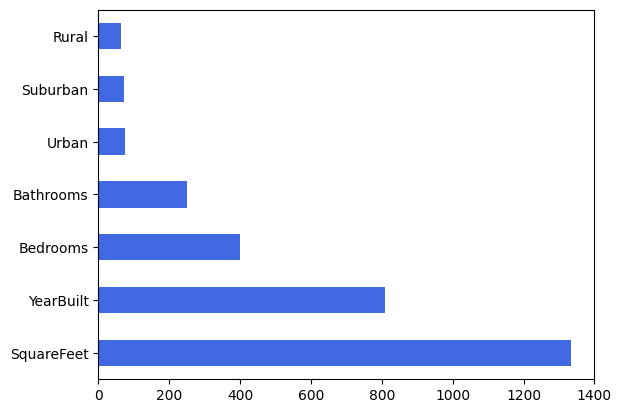

In [33]:
#LGBMRegressor model feature imp
model_feat_imp(LGBMRegressor(force_row_wise=True),"LGBMRegressor",
              (1600,200))

CatBoostRegressor: 
 [70.54923569  7.36975902  4.737074   12.69852544  1.43978042  1.4867228
  1.71890262]


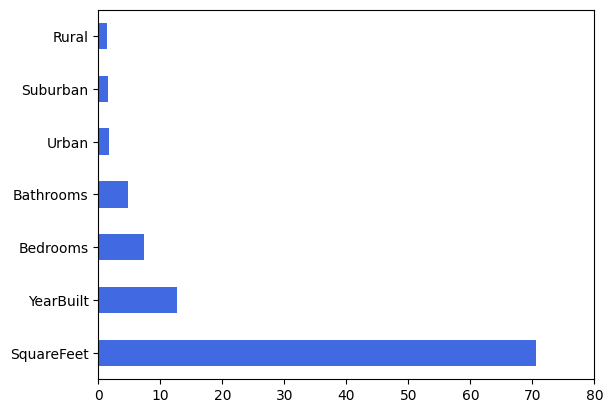

In [34]:
#CatBoostRegressor model feature imp
model_feat_imp(CatBoostRegressor(logging_level='Silent')
                ,"CatBoostRegressor",(90,10))

#### All 3 models: XGRegressor, LGBMRegressor, and CatBoostRegressor, show that squarefeet has the greatest impact on the price of a home. All other features have more minimal impact on price.

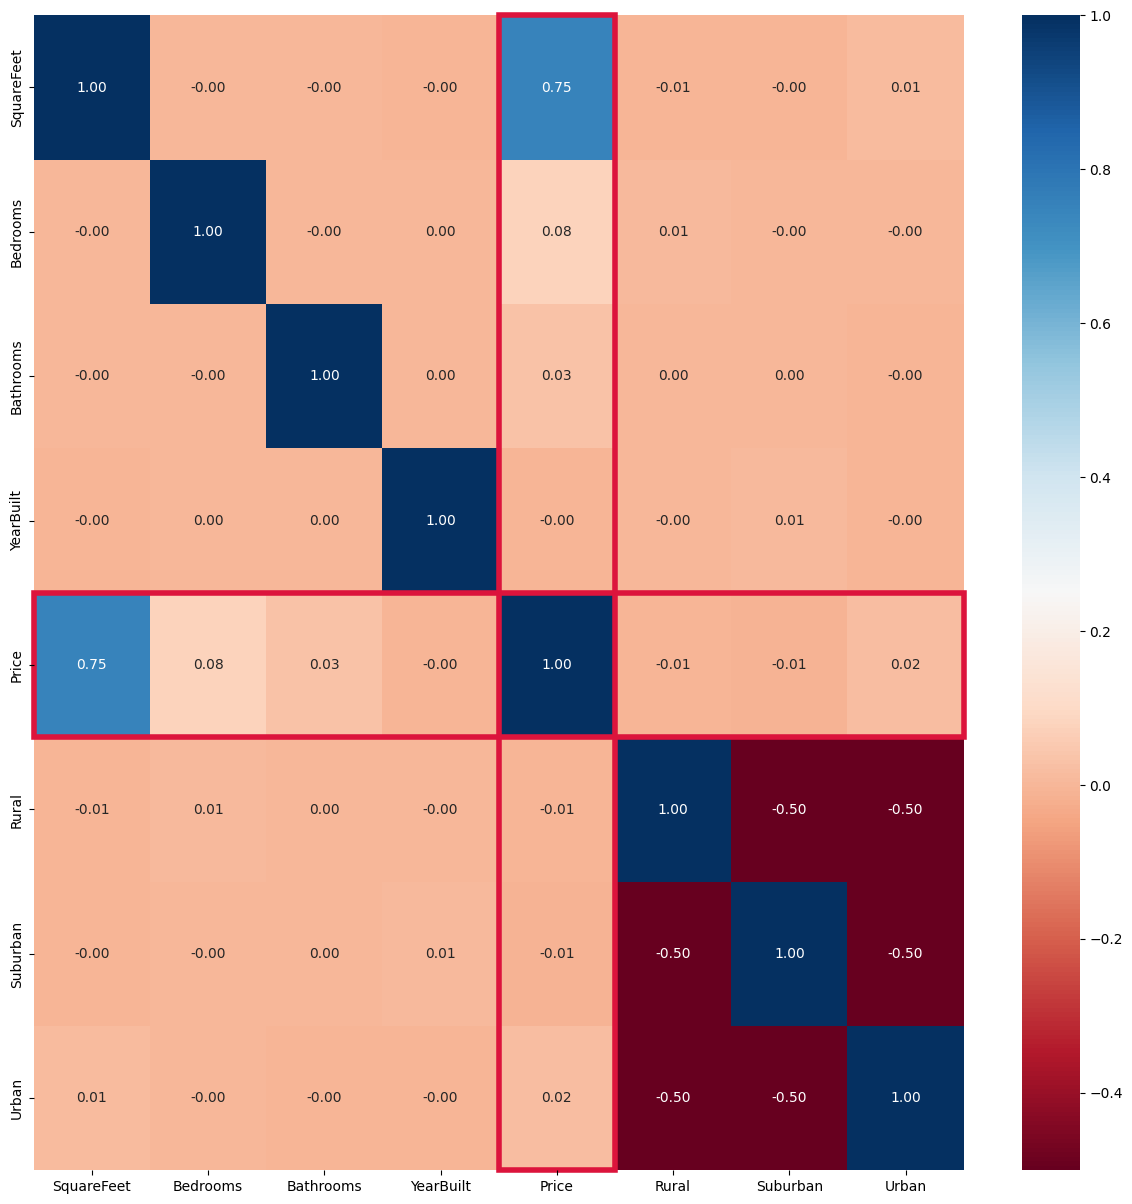

In [35]:
#Using pd.df.corr() which is pd built-in column pairwise-correlation
#calculator. Later used to build heatmap

corr = train.corr(method='pearson')
fix, ax = plt.subplots(figsize=(15,15))
#corr input, RedBlue coloring
sns.heatmap(corr,cmap='RdBu',annot=True,fmt='.2f')

#Following code will mark 'Price' columns for easy
#identification of feature-label correlations

wanted_label = 'Price'
wanted_index = train.columns.tolist().index(wanted_label)
x, y, w, h = 0, wanted_index,num_features+1, 1
for _ in range(2):
    ax.add_patch(Rectangle((x, y), w, h, fill=False, 
                        edgecolor='crimson', lw=4, clip_on=False))
    x, y = y, x # exchange the roles of x and y
    w, h = h, w # exchange the roles of w and h
plt.show()

#### Notable features:
#### 1.SquareFt: 0.75
#### 2.Yearbuilt: 0.00
#### 3.Neighborhood (Avg of Subcats): 0.00
#### Result- Drop Year and Neighborhood

In [36]:
X_train = train.drop(columns=['YearBuilt','Urban','Suburban','Rural'],
                   axis=1)
y_train = train['Price']

In [37]:
X_test = test.drop(columns=['YearBuilt','Urban','Suburban','Rural'],
                   axis=1)
y_test = test['Price']

In [70]:
#Scale X_train and turn it into df usable for Modeling
#StanScalar scales all columns to a Gaussian distribution: 
#     mean = 0, var = 1
#display(X_train.describe())
Scaler = StandardScaler()
X_train = pd.DataFrame(Scaler.fit_transform(X_train))
X_test = pd.DataFrame(Scaler.fit_transform(X_test))
display(X_train.head())
display(X_train.describe())

,0,1,2,3
0,-0.646769,0.445149,-1.226984,-0.643921
1,-0.735538,0.445149,-0.000613,-0.130922
2,-0.189003,-0.452932,1.225758,-0.520620
3,-0.025391,0.445149,-1.226984,-0.055741
4,-0.707689,-1.351014,-0.000613,-0.583097


,0,1,2,3
count,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04
mean,-1.207923e-17,-2.368476e-18,-6.631732e-18,-8.052818e-18
std,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00
min,-1.748541e+00,-1.351014e+00,-1.226984e+00,-3.323088e+00
25%,-8.591169e-01,-4.529325e-01,-1.226984e+00,-7.208288e-01
50%,4.198451e-03,4.451491e-01,-6.131856e-04,6.061589e-03
75%,8.692544e-01,4.451491e-01,1.225758e+00,7.144843e-01
max,1.730829e+00,1.343231e+00,1.225758e+00,3.507009e+00


## Modeling

In [39]:
#Split 20% of full set for validation set (25% of X_train)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)

In [82]:
X_eval=X_eval.reset_index(drop=True)
y_eval=y_eval.reset_index(drop=True)

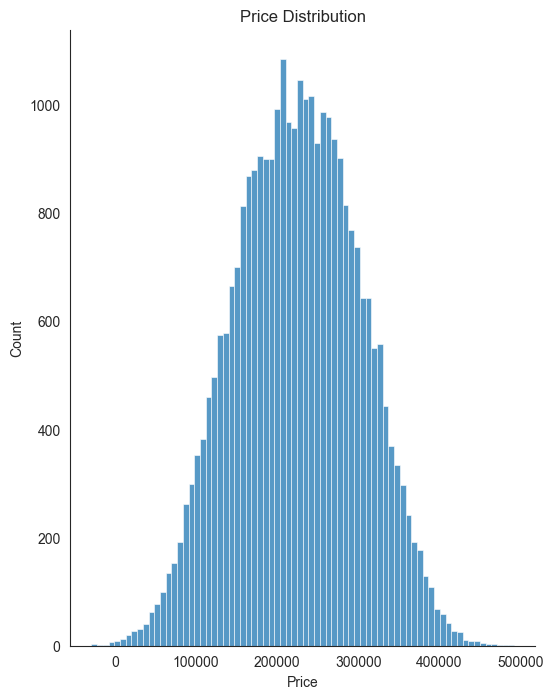

Price:
---------
Skewness: -0.012156
Kurtosis: -0.393865



In [40]:
sns.set_style("white")
sns.set_color_codes(palette="deep")
f, ax = plt.subplots(figsize=(6,8))
sns.histplot(y_train)
ax.xaxis.grid(False)
plt.title("Price Distribution")

sns.despine(trim=False)
plt.show()
print(f"Price:\n---------")
print("Skewness: %f" % y_train.skew())
print("Kurtosis: %f" % y_train.kurt() + "\n")

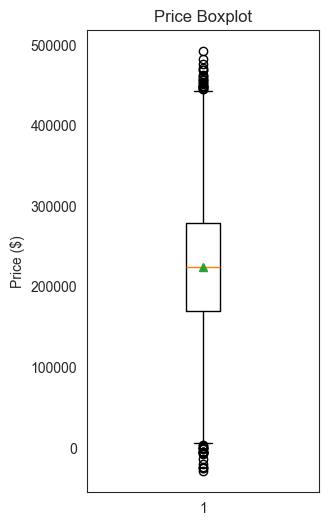

In [41]:
plt.figure(figsize=(3,6))
plt.boxplot(y_train,showmeans=True)
plt.title("Price Boxplot")
plt.ylabel("Price ($)")
plt.show()

In [42]:
#Note that Kaggle user does model.predict on train data but since
#we are doing hyper-parameter tuning, we should use the eval set

#Extra Note: Even better is to do cross validation during hyper-par
#tuning, which is like predicting on eval set except k-fold to
#increase the effect of generalizability 

In [43]:
#Evaluating regression models:
# 1. Mean Absolute Error: The average of the sum of differences between targets and predictions
# 2. MSE (Root Mean Squared Error): The
# 3. R^2: The proportion of variance in Y explained by X. In other words, how well the chosen features explain the variance in the targets.

In [44]:
%%capture
"""
def objective(trial,x,y):
    
    params = {
        'n_estimators':      trial.suggest_int('n_estimators', 300, 4000),
        'learning_rate':     trial.suggest_loguniform("learning_rate", 0.01, 0.1),
        'max_depth':         trial.suggest_int("max_depth", 2, 6), 
        'min_child_weight':  trial.suggest_loguniform("min_child_weight", 0.001, 10),
        'subsample':         trial.suggest_discrete_uniform("subsample", 0.1, 1.0, 0.025),
        'colsample_bytree':  trial.suggest_discrete_uniform("colsample_bytree",  0.1, 1.0, 0.025),
        'colsample_bylevel': trial.suggest_discrete_uniform("colsample_bylevel",  0.1, 1.0, 0.025),
        'gamma':             trial.suggest_loguniform("gamma", 1e-10, 10), 
        'reg_lambda':        trial.suggest_loguniform("reg_lambda", 1e-10, 100),
        'reg_alpha':         trial.suggest_loguniform("reg_alpha", 1e-10, 100),
    } 
    
    
    model = XGBRegressor(**params, objective='reg:absoluteerror')
    #CROSS VALIDATION
    kf = KFold(n_splits=5)
    accuracies = []
    for idx in kf.split(X=x,y=y):        
        train_idx, eval_idx = idx[0], idx[1]

        xtrain = x.iloc[train_idx]
        ytrain = y.iloc[train_idx]
        
        xeval = x.iloc[eval_idx]
        yeval = y.iloc[eval_idx]
        
        model.fit(xtrain,ytrain)
        preds = model.predict(xeval)
        fold_accuracy = median_absolute_error(yeval,preds)
        accuracies.append(fold_accuracy)
    score = np.mean(accuracies)        
    return score

"""

In [45]:
%%capture
"""
optuna.logging.set_verbosity(optuna.logging.DEBUG)
objective_function = partial(objective, x=X_train, y=y_train)
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=123),direction="minimize")
study.optimize(objective_function,n_trials=50)
"""

In [46]:
#study.best_params

In [47]:
%%capture
"""
def objective(trial,x,y):
    
    params = params = {
        'n_estimators'    :trial.suggest_int('n_estimators', 300, 4000),
        'learning_rate':     trial.suggest_loguniform("learning_rate", 0.01, 0.1),
        'max_depth':         trial.suggest_int("max_depth", 2, 6), 
        'min_child_weight':  trial.suggest_loguniform("min_child_weight", 0.001, 10),
        'subsample':         trial.suggest_discrete_uniform("subsample", 0.1, 1.0, 0.025),
        'colsample_bytree':  trial.suggest_discrete_uniform("colsample_bytree",  0.1, 1.0, 0.025),
        'reg_lambda':        trial.suggest_loguniform("reg_lambda", 1e-10, 100),
        'reg_alpha':         trial.suggest_loguniform("reg_alpha", 1e-10, 100),
        'num_leaves':        trial.suggest_int("num_leaves", 2, 40),
        
    } 
    
    
    model = LGBMRegressor(**params, objective='regression_l1',verbose=-1)
    #CROSS VALIDATION
    kf = KFold(n_splits=5)
    accuracies = []
    for idx in kf.split(X=x,y=y):        
        train_idx, eval_idx = idx[0], idx[1]

        xtrain = x.iloc[train_idx]
        ytrain = y.iloc[train_idx]
        
        xeval = x.iloc[eval_idx]
        yeval = y.iloc[eval_idx]
        
        model.fit(xtrain,ytrain)
        preds = model.predict(xeval)
        fold_accuracy = median_absolute_error(yeval,preds)
        accuracies.append(fold_accuracy)
    score = np.mean(accuracies)        
    return score

"""

In [48]:
%%capture
"""
optuna.logging.set_verbosity(optuna.logging.DEBUG)
objective_function = partial(objective, x=X_train, y=y_train)
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=123),direction="minimize")
study.optimize(objective_function,n_trials=50)
"""

In [49]:
#study.best_params

In [50]:
#My chosen best MAD Cost = 310
params_XGBR_best = {'n_estimators': 2647,
 'learning_rate': 0.0707020154488976,
 'max_depth': 5,
 'min_child_weight': 0.27803152557785016,
 'subsample': 0.75,
 'colsample_bytree': 0.375,
 'colsample_bylevel': 0.42500000000000004,
 'gamma': 3.2426161371115346e-08,
 'reg_lambda': 3.3463283800647636e-07,
 'reg_alpha': 0.0037300399755792967}

In [73]:
params_XGBR_best_2 ={'n_estimators': 2565,
 'learning_rate': 0.09732287808197748,
 'max_depth': 6,
 'min_child_weight': 0.007737991528812258,
 'subsample': 0.1,
 'colsample_bytree': 1.0,
 'colsample_bylevel': 0.9,
 'gamma': 1.3007598689577686,
 'reg_lambda': 9.683728618282095e-06,
 'reg_alpha': 0.08617584406570492}

In [51]:
#MAD=272
params_LGBMR_best={'n_estimators': 2393,
 'learning_rate': 0.01215917651565315,
 'max_depth': 4,
 'min_child_weight': 1.8170831936375549,
 'subsample': 0.4,
 'colsample_bytree': 0.9500000000000001,
 'reg_lambda': 0.10200090008522526,
 'reg_alpha': 0.0007740444513560342,
 'num_leaves': 31}

In [74]:
XGBR_model= XGBRegressor(**params_XGBR_best_2, objective='reg:absoluteerror').fit(X_train,y_train)

In [53]:
LGBMR_model=LGBMRegressor(**params_LGBMR_best, objective='regression_l1',verbose=-1).fit(X_train,y_train)

In [83]:
#XGBoost_cv = cross_val_score(XGBR_model,X=X_train,y=y_train, cv=5)
XGBoost_eval_preds = XGBR_model.predict(X_eval)
XGBoost_r2 = r2_score(y_eval, XGBoost_eval_preds)
XGBoost_RMedAE = np.sqrt(median_absolute_error(y_eval,XGBoost_eval_preds))

In [56]:
#LGBM_cv = cross_val_score(LGBMR_model,X=X_train,y=y_train, cv=5)
LGBM_eval_preds = LGBMR_model.predict(X_eval)
LGBM_r2 = r2_score(y_eval, LGBM_eval_preds)
LGBM_RMedAE = np.sqrt(median_absolute_error(y_eval,LGBM_eval_preds))

In [ ]:
#XGBoost_cv = XGBoost_cv.mean()
#LGBM_cv = LGBM_cv.mean()

In [84]:
models_performance = [('XGBoost',XGBoost_r2,XGBoost_RMedAE),('LGBM',LGBM_r2,LGBM_RMedAE)]
columns = ["Model","R^2 Score","RMedAE Score"]
models_summary = pd.DataFrame(data=models_performance, columns=columns)
display(models_summary)

,Model,R^2 Score,RMedAE Score
0,XGBoost,0.999475,18.074009
1,LGBM,0.999644,16.581007


In [63]:
XGBoost_test_preds = XGBR_model.predict(X_test)
XGBoost_RMedAE2 = np.sqrt(median_absolute_error(y_test,XGBoost_test_preds))
XGBoost_r22 = r2_score(y_test, XGBoost_test_preds)
print(XGBoost_RMedAE2)
print(XGBoost_r22)

20.46469752616226
0.9993899406002704
